# Prediciting the price of electricity in selected area of Australia

This dataset consists of raw data containing the current prices, aswell as the predicted demand, for electricity in the regions New South Wales and Victoria.  
Our task is to clean the data and predict whether the price of electricity will rise or fall.  
The target feature is a binary, where 1 represents a price increase and 0 represents a fall in the price of elecftricity.  
Multiple machine learning models will be employed, and we will find the model with the highest degree of accuracy.

### Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Reading data

In [68]:
# Reading training data
raw_df = pd.read_csv('data/train.csv', index_col=0)
raw_df.head()

,nswprice,nswdemand,vicprice,vicdemand,transfer,target
index,,,,,,
0,0.046445,0.378310,0.003467,0.422915,0.414912,0
1,0.037829,0.749182,0.002576,0.590368,0.557456,0
2,0.046806,0.500000,0.003467,0.422915,0.414912,0
3,0.029723,0.362838,0.001874,0.341792,0.682456,1
4,0.053080,0.500595,0.003581,0.557483,0.410088,0


### Data exploration and visualisation

In this section we will explore the data contained in the training dataset.

In [5]:
# Let's look at the shape of the dataset
raw_df.shape

(33994, 6)

We see that the dataset consists of 33994 observations and has 6 features.

In [6]:
# Lets look at what datatypes we have
raw_df.dtypes

nswprice     float64
nswdemand    float64
vicprice     float64
vicdemand    float64
transfer     float64
target         int64
dtype: object

We have five columns consisting of floats, and a taget feature which is an int.

In [7]:
# Check for missing data
raw_df.isna().sum()

nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
target       0
dtype: int64

There are no missing data in the dataset

In [8]:
# Basic statistics
raw_df.describe()

,nswprice,nswdemand,vicprice,vicdemand,transfer,target
count,33994.000000,33994.000000,33994.000000,33994.000000,33994.000000,33994.000000
mean,0.057260,0.422004,0.003422,0.418636,0.496951,0.424604
std,0.052392,0.319866,0.010215,0.293709,0.288964,0.494290
min,-3.354880,-20.103552,-0.229600,-17.996896,-19.382464,0.000000
25%,0.035127,0.310213,0.002277,0.373123,0.414912,0.000000
50%,0.048667,0.444808,0.003467,0.422915,0.414912,0.000000
75%,0.074306,0.537303,0.003467,0.468863,0.605702,1.000000
max,0.979975,0.980809,1.000000,1.000000,1.000000,1.000000


We observe that each feature contain negative values. This must be dealt with, as the price and demand cannot be negative.  
We also see that the target is binary.

<AxesSubplot:>

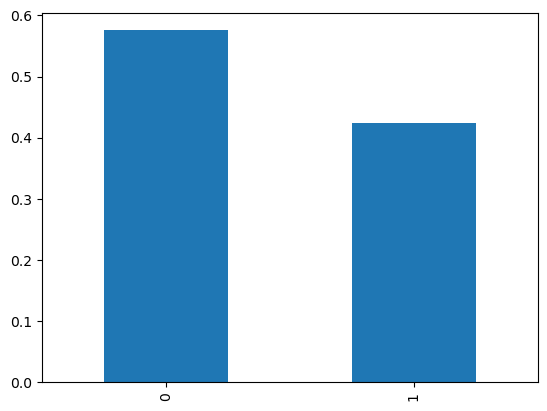

In [9]:
# Lets look at the distribution of the taget feature
raw_df['target'].value_counts(normalize=True).plot(kind='bar')

We observe that the target feature is pretty well balanced.

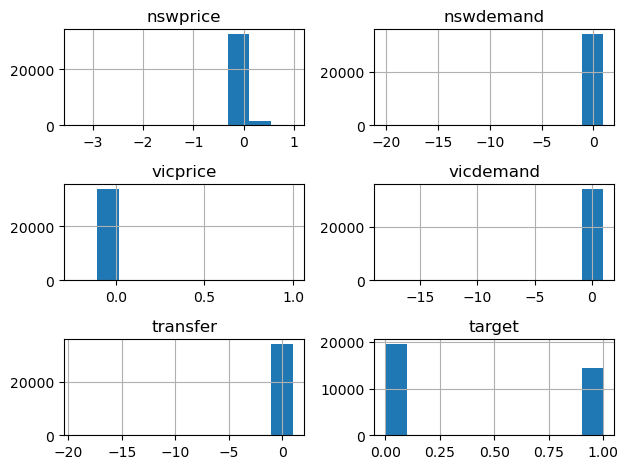

In [10]:
# Let's look at the histograms for each feture
raw_df.hist()
plt.tight_layout()
plt.show()

Looks like most of the features contain negative values.
However, vicprice does not have any negative values.

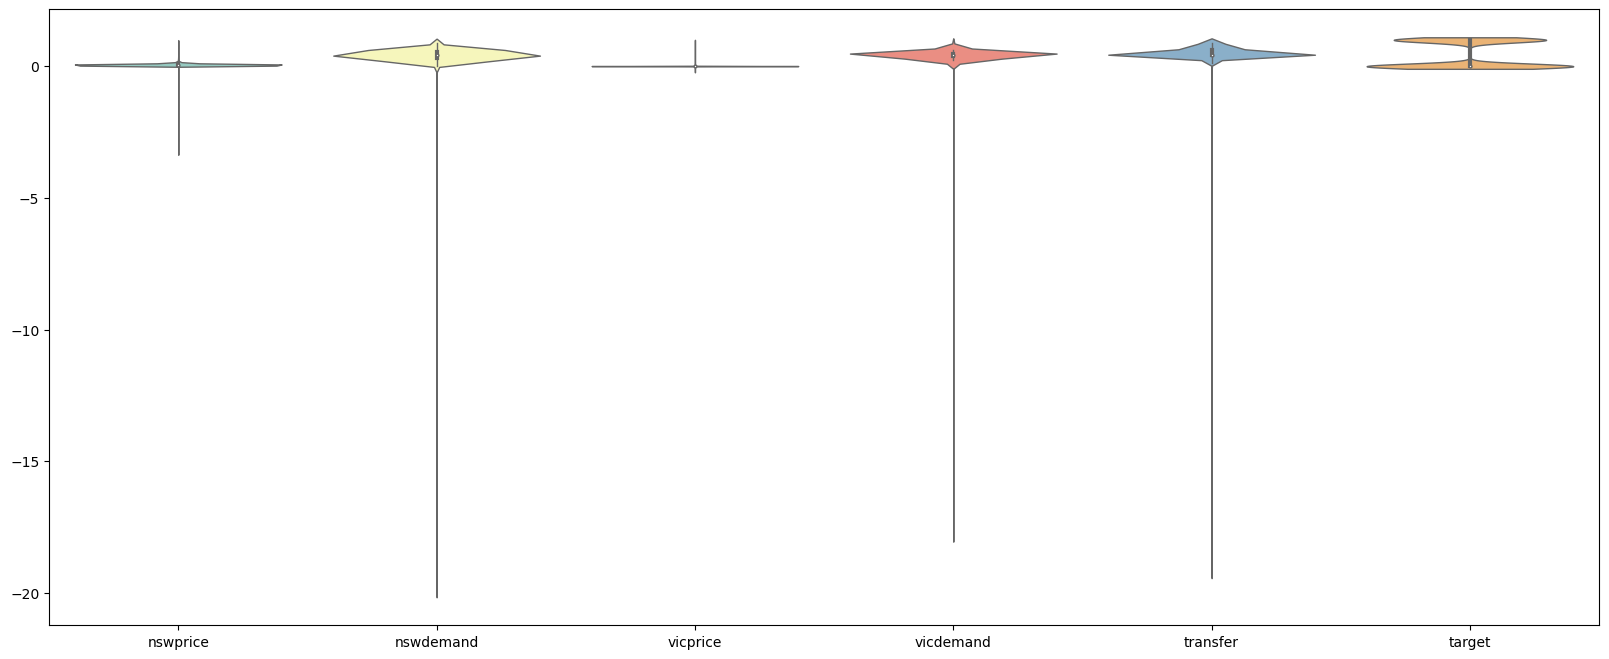

In [11]:
# Let's look at the distribution of the features in a violinplot
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=raw_df, palette="Set3", bw=.2, cut=1, linewidth=1, scale='width')
plt.show()

Looks like most features have negative outliers, while the price features also have positive outliers.  
We will need to clean the dataset to deal with the outliers.

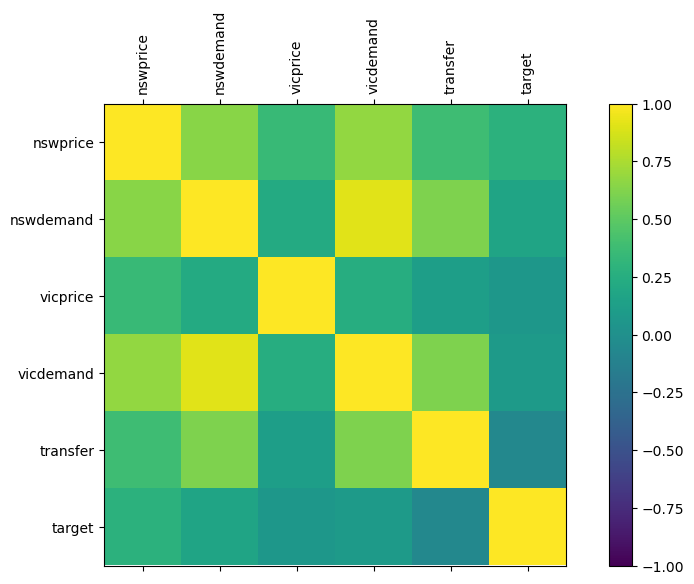

In [12]:
# Now, let's look at the correlations between the features in a correlation matrix
num_vars = raw_df.shape[1]
correlations = raw_df.corr()
fig, ax = plt.subplots(figsize=(11, 6))
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, num_vars, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(raw_df.columns[:]), rotation=90)
ax.set_yticklabels(list(raw_df.columns[:]))
plt.show()


The most highly correlated features are vicdemand and nswdemand, so the electricity demand seems to be quite similar in both of the geographical locations.

### Data cleaning

In [13]:
# Removing the negative values and saving the new dataframe as df
df = raw_df[raw_df.select_dtypes(include=[np.number]).ge(0).all(1)]

In [14]:
# Check the number obervations lost
lost = raw_df.shape[0] - df.shape[0]
print(f'Removing the negative values reulted in a loss of {lost} observations.')

Removing the negative values reulted in a loss of 10 observations.


Losing 10 out of 30k+ obervations is fine.

In [15]:
# Basic statistics
df.describe()

,nswprice,nswdemand,vicprice,vicdemand,transfer,target
count,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000
mean,0.057826,0.426591,0.003459,0.423186,0.501010,0.424553
std,0.039020,0.163117,0.009951,0.120618,0.153238,0.494282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035157,0.310324,0.002279,0.373382,0.414912,0.000000
50%,0.048667,0.444808,0.003467,0.422915,0.414912,0.000000
75%,0.074336,0.537340,0.003467,0.468928,0.605702,1.000000
max,0.979975,0.980809,1.000000,1.000000,1.000000,1.000000


No negative values are observed.

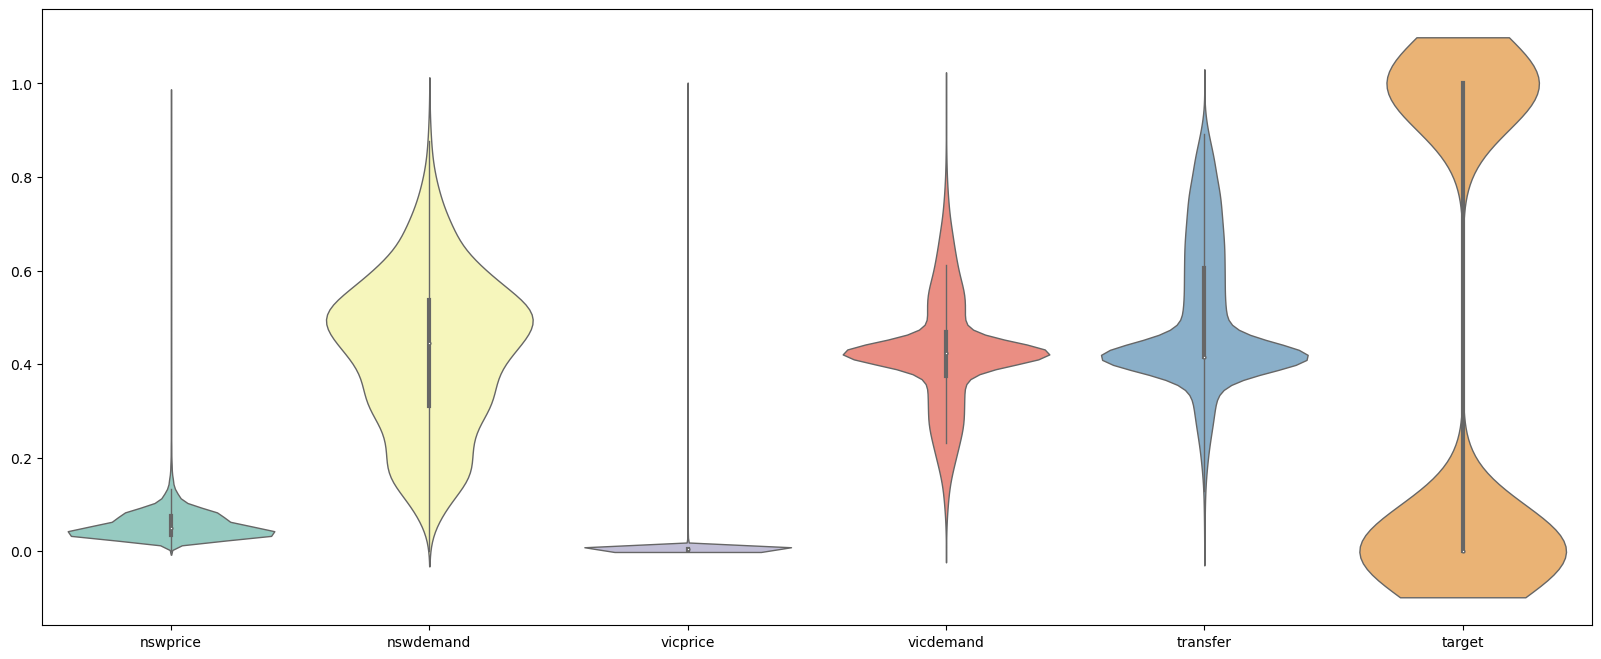

In [16]:
# Let's look at a violinplot again
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=df, palette="Set3", bw=.2, cut=1, linewidth=1, scale='width')
plt.show()

Looks like the price features still have positive outliers. We will remove some more outliers using the IQR method.

In [17]:
def outliers(data):
    sorted(data)
    Q1,Q3 = np.percentile(data , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

nsw_lowerbound,nsw_upperbound = outliers(df['nswprice'])
vic_lowerbound,vic_upperbound = outliers(df['vicprice'])

In [18]:
df.drop(df[ (df['nswprice']>nsw_upperbound) | (df['nswprice']<nsw_lowerbound)].index, inplace=True)
df.drop(df[ (df['vicprice']>nsw_upperbound) | (df['vicprice']<nsw_lowerbound)].index, inplace=True)


In [19]:
lost2 = raw_df.shape[0] - df.shape[0] + lost
print(f'Removing the outliers reulted in a loss of {lost2} more observations.')

Removing the outliers reulted in a loss of 703 more observations.


In [20]:
percent_left = (raw_df.shape[0] - lost - lost2)/raw_df.shape[0] * 100
percent_left 

97.90257104194858

Loss of another 703 obervations out of 30k+ observations is ok.  
We still have 97.9% of the original obervations in the dataset.

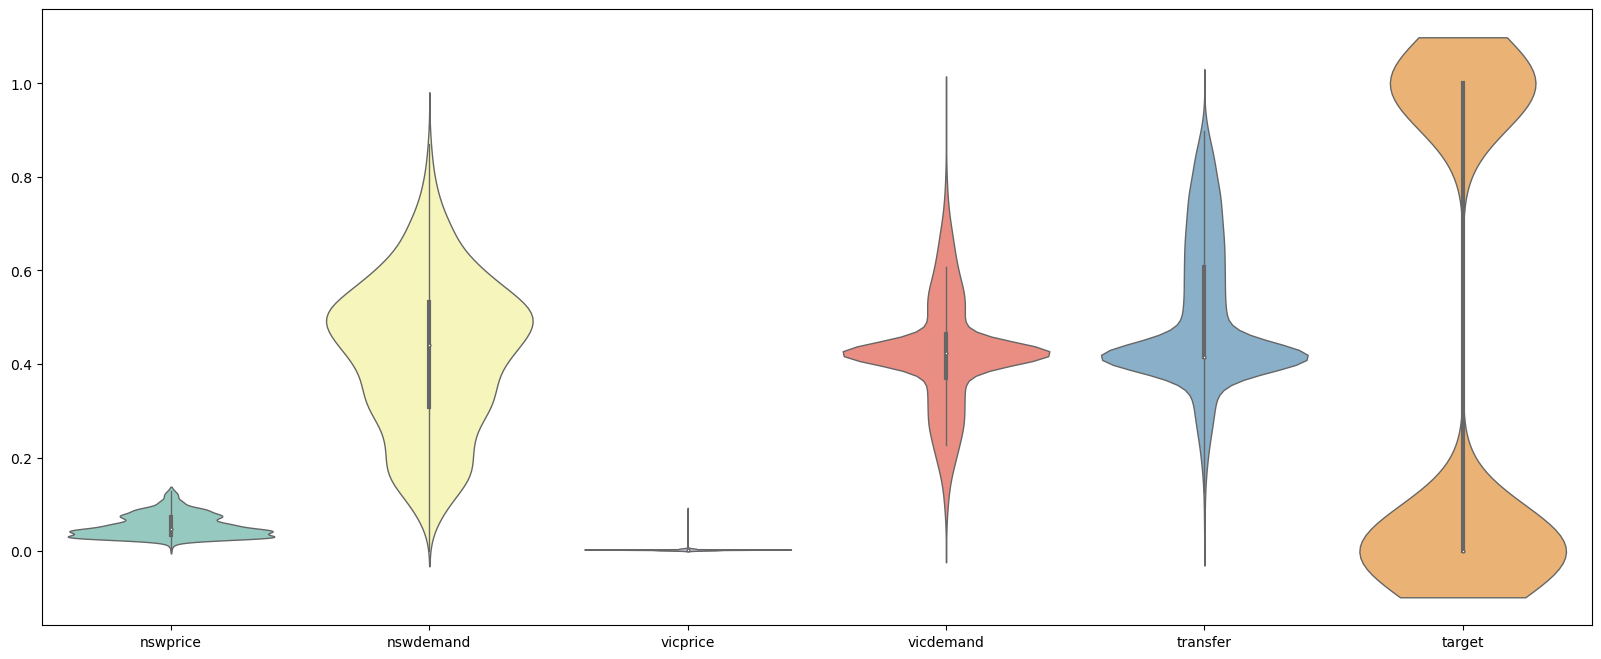

In [21]:
# Violinplot after outlier removal via IQR
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=df, palette="Set3", bw=.2, cut=1, linewidth=1, scale='width')
plt.show()

The price features does not contain many outliers after we removed them via IQR, and we can go on to preprocessing the data.

### Data preprocessing

First we will divide the cleaned train dataset into X_train, X_test, y_train and y_test.  
Then we will standardize the features using StandardScaler.

#### Train test split

In [70]:
X = df.iloc[:, :5].to_numpy()
y = df.iloc[:, -1].to_numpy()

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

#### Scaling

In [72]:
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [73]:
# Test scaing of the trainig data
# We observe that we have a standard normal distribution
print(np.mean(X_train_sc, axis=0))
print(np.std(X_train_sc, axis=0))

[ 4.73953114e-14 -1.12691114e-14 -1.22052466e-13  1.79757215e-13
 -3.55469255e-13]
[1. 1. 1. 1. 1.]


### Modelling

In this section we will find the model that performs the best at predicting the price change in electricity. We will try out the following models: from logistic regression, support vector machines, decision tree, random forest and k-nearest neighbor.  
We will also use gridsearch to find optimal settings for each model.

#### Logistic regression

In [82]:
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_test_sc)

param_grid = {
    'penalty': [None, 'l1', 'l2', 'elastic'],
    'C': [0.1, 0.25, 0.5, 0.75, 0.9],
}

grid = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

best_lr = grid.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 0.9, 'penalty': 'l2'}
0.7436293436293436


Logistic regression gives us an accuracy of 0.7436.  
The best accuracy is obtained using a l2 penalty and an inverse regularization, C = 0.9.

#### KNN

In [23]:
# Fitting the model
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_sc, y_train)

KNeighborsClassifier()

In [24]:
# Predicting y-values from the test data
y_pred = knn.predict(X_test_sc)

In [25]:
# Saving the predictions to csv file
columns = 'index,target'
np.savetxt("data/sample_submission.csv", np.dstack((np.arange(0, y_pred.size),y_pred))[0], delimiter=',', fmt='%i', header=columns, comments='')

### Evaluation

The best performing classifier was k-nearest neighbor using manhattan distance and 5 neighbors, 
thus this is the code shown above for modelling.
Selected results for the classifiers are presented below.

In [26]:
# Perceptron = 0.72695
# Logistic regression = 0.75785
# SVC linerar with high error penalties = 0.75949
# SVC linerar with low error penalties = 0.76958
# Decision tree, gini, depth 4, = 0.76667
# Decision tree, gini, depth 10, = 0.77058
# Decision tree, entropy = 0.76718
# Random forest = 0.73023
# KNN, 2 neighbors, euclidian distance = 0.75179
# KNN, 5 neighbors, euclidian distance = 0.77966
# KNN, 4 neighbors, euclidian distance = 0.77903
# KNN, 5 neighbors, manhattan distance = 0.77954
# KNN, 10 neighbors, manhattan distance = 0.63538
# KNN, 6 neighbors, manhattan distance = 0.77487
# KNN, 4 neighbors, manhattan distance = 0.77248